# Import modules

In [1]:
import requests
import pandas as pd
import numpy as np
from scipy import signal, fftpack
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

# Define functions to read from influxdb

In [3]:
def influx_read(address, params):
    assert isinstance(address, str)
    assert isinstance(params, dict)
    query_result = requests.get(address, params=params)
    return query_result.json()

def generate_influx_query(db, measurement, conditions):
    assert isinstance(db, str)
    assert isinstance(measurement, str)
    assert isinstance(conditions, dict)
    query_string = " AND ".join(["%s %s '%s'" % (i, j['condition'], j['value']) for i, j in conditions.items()])
    query_string = ' '.join(["SELECT value FROM %s WHERE" % measurement, 
        query_string]) 
    return {'db' : db, 'q' : query_string}

# Import modules

In [4]:
# Generate a query for node 6
q = generate_influx_query('poseidon', 'depth_sonic', {'node_id' : {'value' : 6, 'condition' : '='}})

# Print query
print(q)

{'q': "SELECT value FROM depth_sonic WHERE node_id = '6'", 'db': 'poseidon'}


# Read data from influxdb

In [5]:
# Get the data for node 6
depth = influx_read("http://ec2-54-148-229-234.us-west-2.compute.amazonaws.com:8086/query", q)

In [6]:
depth

{'results': [{'series': [{'columns': ['time', 'value'],
     'name': 'depth_sonic',
     'values': [['2016-04-15T19:52:01.253125225Z', 631],
      ['2016-04-15T19:55:06.67301785Z', 500],
      ['2016-04-15T20:01:10.529154146Z', 500],
      ['2016-04-15T20:16:19.407270187Z', 1375],
      ['2016-04-15T20:19:16.061331498Z', 1376],
      ['2016-04-15T20:22:16.748956051Z', 1370],
      ['2016-04-15T20:25:13.592589289Z', 1370],
      ['2016-04-15T20:28:14.544413893Z', 1371],
      ['2016-04-15T20:31:11.404631626Z', 1375],
      ['2016-04-15T20:34:16.318067842Z', 1374],
      ['2016-04-15T20:37:17.950775629Z', 1374],
      ['2016-04-15T20:40:15.047062939Z', 1374],
      ['2016-04-15T20:43:16.041575118Z', 1374],
      ['2016-04-15T20:46:13.256252651Z', 1374],
      ['2016-04-15T20:49:13.970575714Z', 1374],
      ['2016-04-15T20:52:10.774476907Z', 1374],
      ['2016-04-15T20:59:13.85211268Z', 1324],
      ['2016-04-15T21:02:10.699353192Z', 1331],
      ['2016-04-15T21:05:08.053455154Z', 1323],

# Format the data

In [7]:
# Format the data
depth = depth['results'][0]['series'][0]['values']
depth = pd.DataFrame(depth, columns=['time', 'depth_mm'])
depth['time'] = pd.to_datetime(depth['time'])
depth.set_index('time', inplace=True)

# Take a slice of the data from 05/30 to 06/05
depth = depth.loc['2016-05-30':'2016-06-05']

# Plot the data

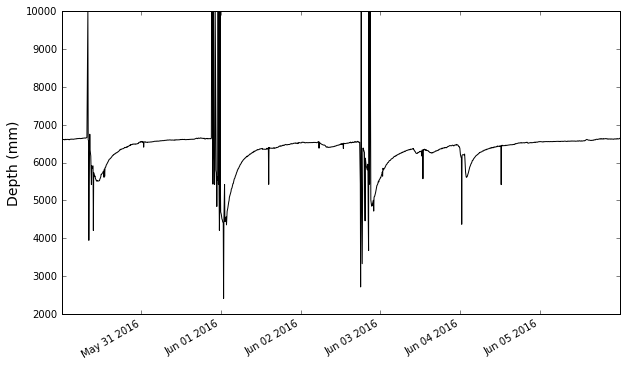

In [8]:
fig, ax = plt.subplots(figsize=(10,6))

depth.plot(ax=ax, legend=False, color='black')
plt.ylabel('Depth (mm)', size=14)
plt.xlabel('')

# Remove error values

In [9]:
# Remove 9999
depth = depth.replace(9999, np.nan).interpolate()

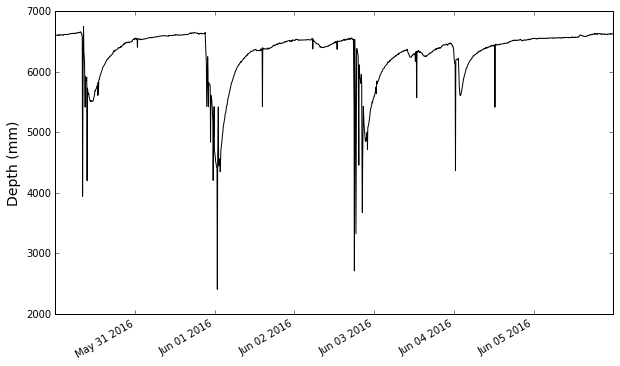

In [10]:
fig, ax = plt.subplots(figsize=(10,6))

depth.plot(ax=ax, legend=False, color='black')
plt.ylabel('Depth (mm)', size=14)
plt.xlabel('')

# Naive approach: remove entries where percent change is large

In [11]:
depth_filtered = depth.where(depth.pct_change().abs() < 0.1).interpolate()

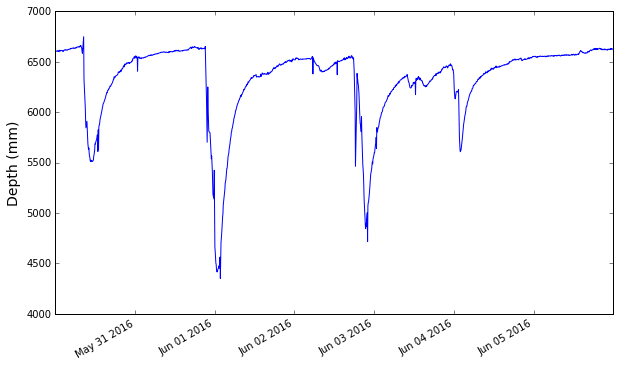

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
depth_filtered.plot(ax=ax, legend=False)
plt.ylabel('Depth (mm)', size=14)
plt.xlabel('')

## Apply a moving average to smooth the data

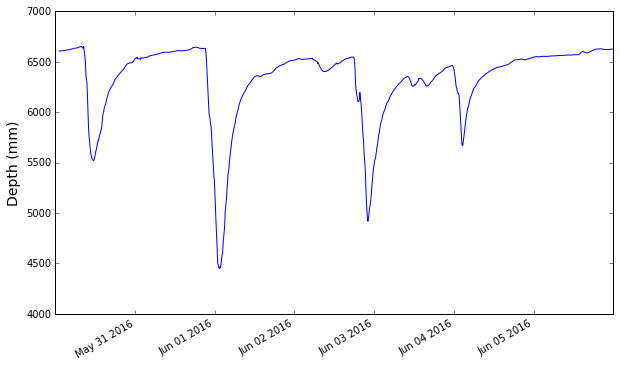

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
pd.rolling_mean(depth_filtered, window=10).plot(ax=ax, legend=False)

plt.ylabel('Depth (mm)', size=14)
plt.xlabel('')

# Advanced approach: remove high frequency noise using a low pass filter

In [14]:
freq_response = np.squeeze(fftpack.fft(depth.values.ravel()))
amp = np.real(freq_response)
phase = np.imag(freq_response)
nyq = 0.5 * 200

b, a = signal.butter(6, 15. / nyq, btype='lowpass')
w, h = signal.freqz(b, a)
y = signal.lfilter(b, a, depth.values.ravel())

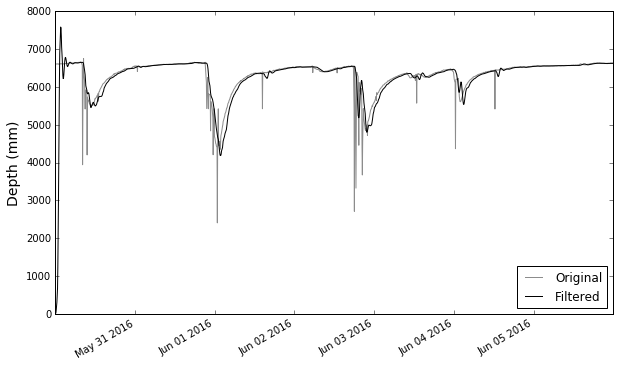

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

pd.Series(depth.values.ravel(), index=depth.index).plot(ax=ax, color='0.55', label='Original')
pd.Series(y, index=depth.index).plot(ax=ax, color='black', label='Filtered')

plt.ylabel('Depth (mm)', size=14)
plt.xlabel('')
plt.legend(loc=4)